<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/main/Intro_to_Data_Processing/03_goodness_of_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Here are some necessary packages that we need to import to run this notebook

import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive 
drive.mount("/content/drive/")

import os
os.chdir("/content/drive/My Drive/DSECOP/Colab Notebooks/")
!pwd

Mounted at /content/drive/
/content/drive/My Drive/DSECOP/Colab Notebooks


# Quantifying goodness of fit

In this notebook, we will learn to quantitatively determine how well a given model describes a dataset. We will do this by introducing the *chi-square* goodness-of-fit test statistic.

## How good is a given fit model?

As covered in the previous notebook, a curve fitting algorithm works in the following manner. 

1. Create a histogram for given dataset with a bin choice $b_i$. The histogram produces a list of counts in each bin, $n_i$. 
 - If your data is not histogrammed (i.e. perhaps you have a scatterplot of measurements as a function of time), you can interpret any dataset pairs ($x_i$, $y_i$) as parallels to the histogram variables ($b_i, n_i$).


2. Define a function $f(b_i, \Theta)$ to fit to the histogram. This function will be calculated at the center of each bin to produce a list of the same length of $n_i$.

3. Select a trial value for the fit parameter(s) $\Theta_{\textrm{trial}}$. Calculate the numbers $f(b_i, \Theta_{\textrm{trial}})$ at each bin center.

4. Calculate the *loss* between the fit function and the data, i.e. between $f(b_i, \Theta_{\textrm{trial}})$ and $n_i$.

4. Repeat steps 3 and 4 for a range of $\Theta_{\textrm{trial}}$ values. 

5. Select the $\Theta_{\textrm{trial}}$ that minimizes the loss. This will produce the best-fitting function to the data.

However, it may be the case that the best-fitting function to the data that is found by the curve fitting algorithm is an objectively *bad*-fitting function. 

As an example: suppose we have a dataset drawn from a parabolic distribution (maybe we're plotting the distance traveled as a funtion of time for an object in free-fall). We *could* fit the plot of distance vs. time to a linear model and get values for the slope and y-intercept that minimize the loss function.


<img src="https://drive.google.com/uc?export=view&id=1w4u7ZYTm50D2HM3Ouin4SWgS0nvih4E9" alt="drawing" width="500"/>



But by eye, we can see that a parabolic fit is superior!

How can we quantitatively describe how good a fit is?

**Activity:** Read in the dataset ```geiger_counts_A.txt``` and histogram it. Fit the data to a Poisson distribution, then a Gaussian distribution. Plot both fits and the histogram on the same plot. By eye, can you decisively determine which model provides a better fit to the data?


In [ ]:
# First histogram the data

dataset_location = "datasets/geiger_counts_A.txt"

def read_in_dataset(file_loc):

  with open(file_loc, "r") as infile:
    dataset = infile.read().split(",")
    num_clicks_per_minute = np.array([int(x) for x in dataset if x != " "])

    return num_clicks_per_minute

num_clicks_per_minute = read_in_dataset(dataset_location)

clicks_per_minute_bin_edges = np.linspace(-.5,30.5,32)
clicks_per_minute_bin_centers = 0.5*(clicks_per_minute_bin_edges[1:]+clicks_per_minute_bin_edges[:-1])

  # We're using np.histogram() here as we don't necessarily need to see the plot of the histogram
n_i, bins = np.histogram(num_clicks_per_minute, clicks_per_minute_bin_edges, density = False)


In [ ]:
# define the fit functions

def poisson(n, l, N):

  return [N*(l**x)*np.exp(-l) / np.math.factorial(x) for x in n]

def gaussian(n, mu, sigma, N):

  return [N*(1.0/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x-mu)**2/sigma**2) for x in n]

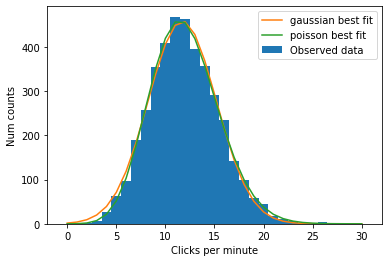

In [ ]:
from scipy.optimize import curve_fit


popt_poisson, pcov_poisson = curve_fit(poisson, clicks_per_minute_bin_centers, n_i)
popt_gaussian, pcov_gaussian = curve_fit(gaussian, clicks_per_minute_bin_centers, n_i, p0 = [12, 5, 3000])

plt.figure()
plt.hist(num_clicks_per_minute, bins = clicks_per_minute_bin_edges, label = "Observed data")
plt.plot(clicks_per_minute_bin_centers, gaussian(clicks_per_minute_bin_centers, *popt_gaussian), label = "gaussian best fit")
plt.plot(clicks_per_minute_bin_centers, poisson(clicks_per_minute_bin_centers, *popt_poisson), label = "poisson best fit")

plt.legend()

plt.xlabel("Clicks per minute")
plt.ylabel("Num counts")
plt.show()

## Defining the $\chi^2$ test statistic

The *chi-square* goodness-of-fit test statistic is defined as

$$\chi^2 = \sum_i \frac{(O_i - E_i)^2}{E_i},$$

where $O_i$ is the observed value for a given bin $b_i$ and $E_i$ is the expected value for that bin, as calculated from the model fit function.

Using terms we have already defined, this is equivalent to 

$$\chi^2 = \sum_i \frac{(n_i - f(b_i, \Theta))^2}{f(b_i, \Theta)}.$$




### Comparing the $\chi^2$ test statistic and loss functions

Looking at the expression for $\chi^2$ above, you might have noticed how similar it looks to the expression for the mean-squared error loss in the previous notebook.

$$\chi^2 = \sum_i \frac{(n_i - f(b_i, \Theta))^2}{f(b_i, \Theta)} \;\;\; \textrm{vs.} \;\;\; \mathcal{L}_{MSE}(\Theta) = \frac{\sum_i (n_i - f(b_i, \Theta))^2}{\textrm{num. bins}}$$

However, these quantities do not gauge the same thing.

Loss functions are used to find the variables $\Theta$ (sometimes called the *parameters*) associated with a given model. You might use a loss function when you know the general analytical process that governs a given dataset, and you want to find specific constants that would lead to the exact numerical data that you observed. For example, maybe you have a plot of the distance a body falls on Mars as a function of time. You are pretty sure that this data should be parabolically distributed, but you use a loss function to best fit the data to a parabola to find the value of $g_{Mars}$.

In contrast, the $\chi^2$ is used to evaluate how well the data fits the predictions of a fully determined model. So maybe you measure the mass and radius of Mars to calculate $g_{Mars}$ from a theoretical standpoint. You can then calculate $\chi^2$ between the theoretical prediction and your observations.



**Activity:** Write a function to calculate the $\chi^2$ test statistic given two arrays ```observed_vals``` and ```expected_vals```. Calculate $\chi^2$ for both the Poisson and the Gaussian fit. Now can you decisively determine which model provides a better fit to the data?

In [ ]:
def chi2(observed_vals, expected_vals):

  chi2 = 0

  for i in range(len(observed_vals)):

    chi2 += ( (observed_vals[i] - expected_vals[i])**2 / expected_vals[i] )
  return chi2

exp_gaussian = gaussian(clicks_per_minute_bin_centers, *popt_gaussian)
exp_poisson = poisson(clicks_per_minute_bin_centers, *popt_poisson)

chi2_gaussian = chi2(n_i, exp_gaussian)
chi2_poisson = chi2(n_i, exp_poisson)

print("$\chi^2$ for a gaussian fit:", chi2_gaussian)
print("$\chi^2$ for a Poisson fit:", chi2_poisson)

$\chi^2$ for a gaussian fit: 158.5802040119228
$\chi^2$ for a Poisson fit: 24.961948378337947


A related test statistic is $\chi^2/\nu$, or the *reduced chi-square*, or the *chi-square per degrees of freedom*.

The degrees of freedom $\nu$ is equal to (num. observations made) - (num. fit parameters in the model).

*Note*: There's a bit of ambiguous language here. Here, an "observation" is equivalent to observing $n_i$ counts in a given bin $b_i$. It is *not* equal to the number of measurements in a given dataset.

**Activity**: Calculate the reduced chi-square, $\chi^2 / \nu$, for the Poisson and Gaussian fit to the dataset.

In [ ]:
dof_gaussian = len(clicks_per_minute_bin_centers) - 2
dof_poisson = len(clicks_per_minute_bin_centers) - 1

print("$\chi^2$ / DoF for a gaussian fit:", chi2_gaussian / dof_gaussian)
print("$\chi^2$ / DoF for a Poisson fit:", chi2_poisson / dof_poisson)

$\chi^2$ / DoF for a gaussian fit: 5.468282896962855
$\chi^2$ / DoF for a Poisson fit: 0.8320649459445982


### A mathematical aside: $\chi^2$ distribution

To fully understand the usefulness of the $\chi^2$ test statistic, we need to understand the $\chi^2$ distribution. The $\chi^2$ distribution is a probability distribution $f(x)$ given by

$$f_k(x) = \frac{x^{k/2 -1}e^{-x/2}}{2^{k/2}\Gamma(k/2)}, \hspace{7mm} (x \geq 0).$$

Here, $\Gamma(k/2)$ is the *Gamma function*. It's defined on integers by $\Gamma(m) = (m-1)!$ and is extrapolated to be well-defined on non-integers. 

To construct the probability distribution $f(x)$, we would execute the following steps:

1. Draw $k$ independent trials from the *standard normal* distribution (a gaussian with $\mu$ = 0 and $\sigma = 1$) to produce a list of measurements $z_1$, ..., $z_k$
2. Calculate the sum of the squares $Q = \sum_{i=1}^k z_i^2$

If steps 1 and 2 are repeated many times, then the variable $Q$ can be histogrammed to produce $f(x)$.


A plot from [Wikipedia](https://en.wikipedia.org/wiki/Chi-squared_distribution) is shown below, for a range of $k$ values.


<img src="https://drive.google.com/uc?export=view&id=1tNO8htoUOzD6BzFSR7v-BKcnRkIgluRt" alt="drawing" width="400"/>





### Adding in physical context: f(x) and the $\chi^2$ test statistic

Now, let's outline how we can recover this theoretical distribution for $f(x)$ from a more realistic physical experiment.

Let's go back to your Geiger counter radioactivity experiment with the Uranium-241 sample. You record the number of counts per minute for as long as you can stand. At the end of that time period, you histogram your measurements using the binning scheme $b_i$ to get counts $n_i$ (let's assume $n_i$ are the normalized counts), fit the histogram to a Poisson distribution, and get a best-fit value $\lambda$.


The parameter $\lambda$ that you found each day should be close to the true value $\lambda^*$ of the theoretical poisson decay process for Urainium-241. But it will likely *not* match. The real world is noisy and messy, and real experiements are rife with fluctuations and statistical errors. However, the more measurements you take, the closer $\lambda$ will be to $\lambda^*$.


For each bin $b_i$, the true underlying process $\lambda^*$ would produce  $n_i^*$ (normalized) for each bin. Again, this will almost certainly differ from the observed $n_i$ counts that you get in your experiment. 

Let's say you do the Geiger counting experiment for several days in a row using the same binning scheme. By the [Central Limit Theorem](https://), the observation for each bin $n_i$ that you get each day will be randomly pulled from a gaussian with mean $n_i^*$ and standard deviation $\sqrt{n_i^*}$.

*Note:* If you are familiar with the Central Limit Theorem, you may know that the standard deviation should be $\frac{\sigma}{\sqrt{n}}$, where $\sigma$ is the standard deviation of the underlying process and $n$ is the number of measurements made. For counting experiemnts, the error on the number of counts $m$ in a bin is $\sqrt{m}$, and each day, we make one measurement per bin.

Then we have

$$\chi^2 = \sum_i \frac{(n_i - n_i^*)^2}{n_i}.$$

Now consider the quantity $\frac{(n_i - n_i^*)^2}{n_i}$ calculated for each bin $b_i$. Since we can identify $\sigma_i^2$ with $n_i$, then the quantity is equal to the normalized variance. In other words, it's the variance for a random process pulled from a standard normal distribution. And this was the theoretical underpinning of the $\chi^2$ distribution $f(x)$ -- we have completed the circle, and expressed the $\chi^2$ as the sum of many normalized variances!

*Note:* There's a subtlety here -- while $f(x)$ was defined as the sum over $k$ independent measurements, we identify $k$ not with the number of bins $I$, but rather with the degrees of freedom $\nu$ for our model fit. This is because our random draws of histograms bins are not actually independent for a normalized distribution. (Can you see why the individual bins for a histogram wouldn't be independent?)

### Using the $\chi^2$ test statistic to evaluate a model

In the doing the previous exercises, you may have come to the conclusion that a lower $\chi^2$ test statistic is generally better, as we have better agreement between the observed data and the results predicted by the model. But how can we turn this general sentiment into something more rigorous?

### The language of hypothesis testing

At this point, it is useful to introduce the idea of hypothesis testing. In this framework, we define two hypothesis:

$\mathcal{H_0}$ , the null hypothesis: this is the situation where the model fit we have defined **does** describe the data.

$\mathcal{H_1}$, the alternative hypothesis: this is the situation where the model fit we have defined **does not** describe the data.

When we do a hypothesis testing analysis, we operate under the assumption that the null hypotehsis is true. In other words, we postulate (possibly incorrectly) that the model fit we have derived from out dataset is the *correct* model that describes the underlying physics process that we measured. So if your Poisson fit to the Geiger counter data returned a best-fit value for $\lambda$ = 35 counts per minute, then we make the claim that the sample fo Uranium-241 does indeed have a true decay rate of 35 counts per minute, i.e. $\lambda^* = \lambda$. 

Now, let's say that you give the Uranium-241 sample to $i$ different friends over the course of a week, and they all make their own counts per minute datasets. Due to random statistical fluctuations, none of your friends will produce the *same* dataset. But, if your friends do a fit to their individual datasets using the same binning scheme as you did, they should find that the data is indeed Poisson distributed with $\lambda_i \sim $ 35. Your friends can then calculate their own measurements of $\chi^2_i$. And the collection of $\chi^2_i$ measurements mase by you and your friends should follow the a theoretical chi-square proability distribution with $\nu$ degrees of freedom $f_\nu(x)$. 

### Significance and $p$-values

All of the above scenario was created under the claimm that the null hypothesis was true. Now it's time to check whether that claim was a good one to make.

For each measurement $\chi^2_i$ that your friends make, we can define the quantity $\alpha$ (sometimes called the *$p$-value* as 

$$\alpha = \int_{\chi^2_i}^\infty f_k(x) dx.$$

We can interpret $\alpha$ as the probability that an arbitrary experiment of the same type would result in a measured value of $\chi^2$ that is *greater* than the value $\chi^2_i$. 

If $\alpha$ is very small, this means that it would be very unlikely to measure a value of $\chi^2$ greater than $\chi^2_i$. There are two possbilities as a result: 

1. The null hypothesis is true, and the dataset that made an abnormally large measurement of $\chi^2_i$ was a rare statistical anomaly. 
2. The null hypothesis is *not* a good description of the data.

Most times, a $p$-value of 0.05 is considered sufficient to reject the null hypothesis. 

<a href="https://www.simplypsychology.org/p-value.html">
<img src="https://drive.google.com/uc?export=view&id=1zFUzppFzicwLM2KqqAPam-aecOrFsUVn" alt="drawing" width="500"/>


In practice, if you don't feel like writing code to calculate the $\chi^2$ test statistic yourself, you can use the ```scipy.stats.chisquare()``` method.

The function takes three main arguments: 

1. ```f_obs```: a ```np.array``` (or ```list```)  containing the observed data counts /  frequencies
2. ```f_exp```: a ```np.array``` (or ```list```)  containing the expected data counts /  frequencies
3. ```ddof```: an ```int``` containing the number of degrees of freedom corresponding to the model fit.Recall that we defined $\nu$ as (num. observations made) - (num. fit parameters in the model). ```scipy.stats.chisquare()``` infers (num. observations made) from ```f_obs``` and ```f_exp```, so ```ddof`` is just the "delta" to this value.

The function returns the (unscaled) $\chi^2$ test statistic and the $p$-value ($\alpha$), as derived from comparing the calculated $\chi^2$ with the theoretical $\chi^2$ distribution with the relevant degrees of freedom. 

You can read more about the function [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html).

**Activity**: Accept or reject the null hypothesis using the $\chi^2$ test statistic, assuming (1) a Poisson model and (2) a gaussian model.

In [ ]:
from scipy.stats import chisquare

result_gaussian = chisquare(n_i, exp_gaussian, 2)
result_poisson = chisquare(n_i, exp_poisson, 1)

print("$\Chi^2$ for gaussian fit =", result_gaussian)
print("$\Chi^2$ for poisson fit =", result_poisson)

$\Chi^2$ for gaussian fit = Power_divergenceResult(statistic=158.5802040119228, pvalue=3.442260037741459e-20)
$\Chi^2$ for poisson fit = Power_divergenceResult(statistic=24.961948378337947, pvalue=0.6802205648039448)


## Bonus: The Kolmogorov-Smirnov goodness-of-fit test.

In this notebook, we've focused on the $\chi^2$ test statistic. But this test is only truly useful for categorical data (i.e. datasets of counts or frequencies). For histogram-based analyses, the number of "categories" could maybe be considered equal to the number of binsm, but it might be easier to work with normalized histograms anyways. Then the $\chi^2$ test statistic might fail to gauge goodness-of-fit for a given model.

A useful goodness-of-fit procedure for histogram-based analyses is the *Kolmogorov-Smirnov* test.

Consider a data sample of size $n$ with a probability distribution $p_n(x)$ (in other words, the normalized histogram) and a cumulative distribution function (CDF) $F_n(x)$. Let's say that you want to test whether the data can be well-modeled by the probability distribution $p_0(x)$ with a cumulative distribution function $F_0(x)$.

The Kolmogorov-Smirnov test statistic is

$$D_n = \max_x |F_n(x) - F_0(x)|.$$

In essense, we're calculating the largest difference between the CDFs of the data and the postulated model. (It should be clear that for a model that perfectly fits the data, $D_n = 0$.)

Each $n$ and $\alpha$ ($p$-value) pairing is associated with a critical test statistic $d_{n, \alpha}$. You can find these in a [lookup table](https://www.real-statistics.com/statistics-tables/two-sample-kolmogorov-smirnov-table/). If $D_n > d_{n, \alpha}$, then the null hypothesis must be rejected at the given confidence level. 

*Note*: the Kolmogorov-Smirnov test is defined for *unbinned* data with a continuous CDF. Here, we're asking you to run the test on Poisson-distributed data, which is discrete (as you can only measure an integer number of counts). So take this example with a grain of salt. In writing code to do a pseudo- Kolmogorov-Smirnov test, you'll gain conceptual understanding in what the test actually measures. But you won't be able to meaningfully accept of reject the null hypothesis. 

**Activity**: write code to run a *binned* Kolmogorov-Smirnov test on the (1) gaussian and (2) poisson fit to data. Plot CDFs of the two fits and the actual data on the same plot. For each fit, print out the test statistic $D_n$ and its bin location.

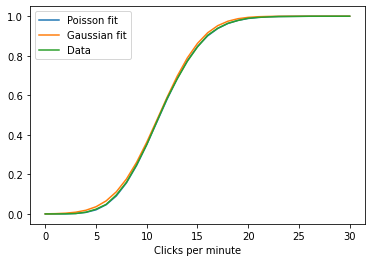

KS statistic for gaussian fit = 0.01777623541426221 at 15.0
KS statistic for poisson fit = 0.00478921792972363 at 7.0


In [ ]:
def KS_test(pdf_1, pdf_2):

  # calculate the CDFs
  CDF_1 = np.cumsum(pdf_1) / np.sum(pdf_1) 
  CDF_2 = np.cumsum(pdf_2) / np.sum(pdf_2) 

  D_n = max(np.abs(CDF_1 - CDF_2))
  arg_max = np.argmax(np.abs(CDF_1 - CDF_2))

  return D_n, arg_max


CDF_data = np.cumsum(n_i) / np.sum(n_i) 
CDF_gaussian = np.cumsum(exp_gaussian) / np.sum(exp_gaussian) 
CDF_poisson = np.cumsum(exp_poisson) / np.sum(exp_poisson) 

KS_gaussian = KS_test(n_i, exp_gaussian)
KS_poisson = KS_test(n_i, exp_poisson)


plt.figure()
plt.plot(clicks_per_minute_bin_centers, CDF_poisson, label = "Poisson fit")
plt.plot(clicks_per_minute_bin_centers, CDF_gaussian, label = "Gaussian fit")
plt.plot(clicks_per_minute_bin_centers, CDF_data, label = "Data")
plt.xlabel("Clicks per minute")
plt.legend()
plt.show()

print("KS statistic for gaussian fit =", KS_gaussian[0], "at", clicks_per_minute_bin_centers[KS_gaussian[1]])
print("KS statistic for poisson fit =", KS_poisson[0], "at", clicks_per_minute_bin_centers[KS_poisson[1]])


In [ ]:
# https://www.real-statistics.com/statistics-tables/kolmogorov-smirnov-table/


D_n = .0388
KS_table = {.001:1.94947, .01:1.62762, .05:1.35810, .1:1.22385 }

for p_val in KS_table.keys():
  d_crit = KS_table[p_val]/np.sqrt(sum(n_i))
  print("For p value =", p_val, ", d_crit =", d_crit)
  if D_n > d_crit:
    print("Reject at", p_val)
  else:
    print("Accept at", p_val)
  print()

For p value = 0.001 , d_crit = 0.030823827150842253
Reject at 0.001

For p value = 0.01 , d_crit = 0.02573493182621629
Reject at 0.01

For p value = 0.05 , d_crit = 0.021473446451373383
Reject at 0.05

For p value = 0.1 , d_crit = 0.019350767571985356
Reject at 0.1



The relevant built-in function for the Kolmogorov-Smirnoff test is ```scipy.stats.kstest()```. 

The function takes three main arguments: 

1. ```x```: a ```np.array``` (or ```list```)  containing the raw observed data. Note that is NOT the histogrammed data. 
2. ```cdf```: this is usually a string describing the random variable of the model that you want to fit. If you wanted to fit a Gaussian distribution, you could use the string ```"norm"```.
3. ```args```: parameters of the model. For a Gaussian distribution, this would be ```(mu, sigma)```.

The function returns the test statistic $D_n$ and the associated $p$-value. 

You can read more about the function [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest).

Another common application of the Kolmogorov-Smirnoff test is to compare two distributions to determine if they came from the same underlying model, as opposed to comparing a single distribution to a model. Then you might want to use the function ```scipy.stats.ks_2samp()```.


The function takes two main arguments: 

1. ```data_1```: a ```np.array``` (or ```list```)  containing the raw observed data of sample 1. Note that is NOT the histogrammed data. 
2. ```data_2```: a ```np.array``` (or ```list```)  containing the raw observed data of sample 2.


The function returns the test statistic $D_n$ and the associated $p$-value. 


You can read more about the function [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html).

*Notebook finished*